## Exploratory Data Analysis

#### Load packages and data

In [1]:
# LOAD PACKAGES
import os 
from tqdm import notebook
import pathlib
import pickle as pkl
import matplotlib
import gdown
import itertools
from pooch import DOIDownloader

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re
from data_preperation import *

In [ ]:
# DOWNLOAD DATA FROM WEB
download_shormccarty()
download_chorus()

In [2]:
# LOAD DATA FROM FILE 
chorus_folder = "../data/raw/chorus"
bills = pd.read_parquet(os.path.join(chorus_folder, "bills.parquet"))
positions = pd.read_parquet(os.path.join(chorus_folder, "positions.parquet"))
blocks = pd.read_parquet(os.path.join(chorus_folder, "block_assignments.parquet"))

ideology = pd.read_csv("../data/raw/shormccarty/state_ideology.tab", sep='\t')

#### Subset data
- States with lobbying records: ["IA", "MA", "NE", "NJ", "RI", "WI"] 
- Years where all relevant data (ideology, positions, bills) is available for each state: 
    - IA: 2009-2020
    - MA: 2009-2020
    - NE: 2010-2020
    - NJ: 2014-2020
    - RI: 2018-2020
    - WI: 2009-2020

In [3]:
states_lobby = ["IA", "MA", "NE", "NJ", "RI", "WI"] 
state_name_dicts = dict(zip(states_lobby, ["iowa", "massachusetts", "nebraska", "new jersey", "rhode island", "wisconsin"]))
time_ranges = [range(2009, 2021), range(2009, 2021), range(2010, 2021), 
               range(2014, 2021), range(2018, 2021), range(2009, 2021)]
states_palette = dict(zip(states_lobby, sns.color_palette("viridis", 6).as_hex())) #palette for plots
states_markers = dict(zip(states_lobby, ['o', 'D', 's','P', 'X',  'd']))

##### BILLS

In [ ]:
#BILLS:
bills_sub = clean_bills(bills, states_lobby, time_ranges, state_name_dicts)
print(f"Total number of samples (bills) after cleaning: {len(bills_sub)}\n")
print(f"Proportion of bills passed and failed:\n{bills_sub["pass"].value_counts(normalize = True)}\n")
print(f"Number of bills passed and failed:\n{bills_sub["pass"].value_counts()}")
print(f"\nProportion of bills with one or more assigned metatopics:\n{bills_sub["ncsl_metatopics"].apply(lambda x: "no NCSL topics" if x == ["M"]  else "assigned NCSL topic").value_counts(normalize=True)}")
print(f"\nSamples (bills) per state and status:\n{bills_sub.value_counts(["state", "pass"], sort=False).T}")

bills cleaned
Total number of samples (bills) after cleaning: 127752

Proportion of bills passed and failed:
pass
failed    0.880182
passed    0.119818
Name: proportion, dtype: float64

Number of bills passed and failed:
pass
failed    112445
passed     15307
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2172324 stored elements and shape (127752, 26032)>

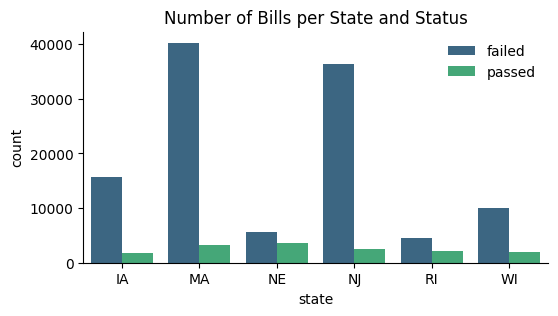

In [6]:
#PLOT BILLS: STATUS
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(bills_sub, x = "state", hue = "pass",stat = "count", palette= "viridis")
sns.move_legend(p, "upper right", frameon = False, title=None)
ax.set_title('Number of Bills per State and Status')
sns.despine()
plt.savefig("../figs/bills_status.png", bbox_inches='tight', dpi = 1000)

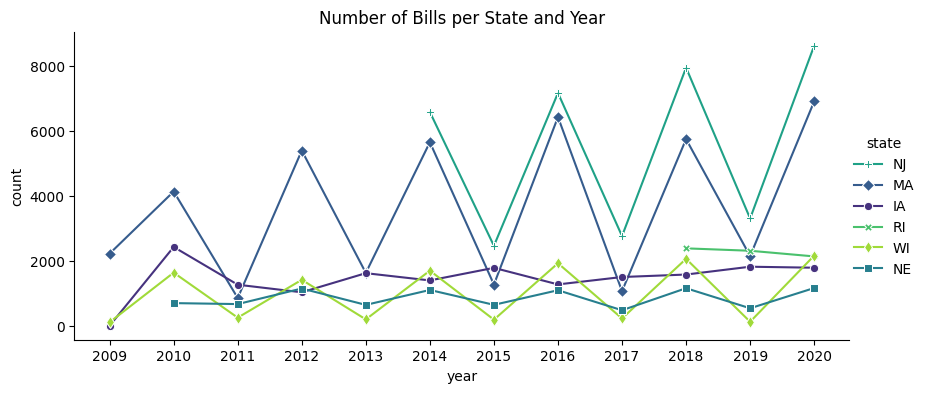

In [8]:
#PLOT BILLS: COUNTS (LINEPLOT)
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = bills_sub.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, 
                 style="state", markers=states_markers, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.7),  frameon = False)
sns.despine()
ax.set_title('Number of Bills per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020'])
plt.savefig("../figs/bills_lineplot.png", bbox_inches='tight', dpi = 1000)

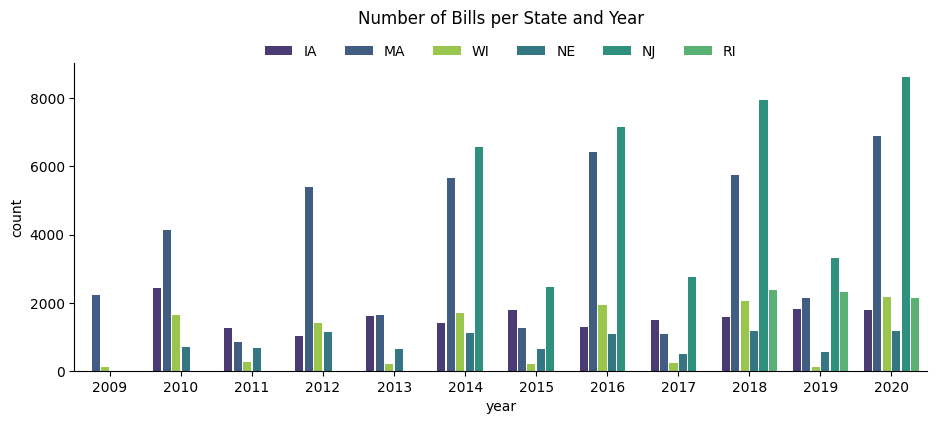

In [9]:
#PLOT BILLS: COUNTS (BARPLOT)
fig, ax = plt.subplots(figsize=(11, 4))
p = sns.countplot(bills_sub, x="year", hue="state", stat="count", palette=states_palette, gap=.15)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Bills per State and Year', y=1.1)
sns.despine()
plt.savefig("../figs/bills_barplot.png", bbox_inches='tight', dpi=1000)

number of unique topics: 862
number of unique metatopics: 18


/tmp/ipykernel_6669/2076364674.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.append(bills_sub["ncsl_metatopics"].explode().unique()[::-1][0:-1], "No NCSL metatopic assigned"))


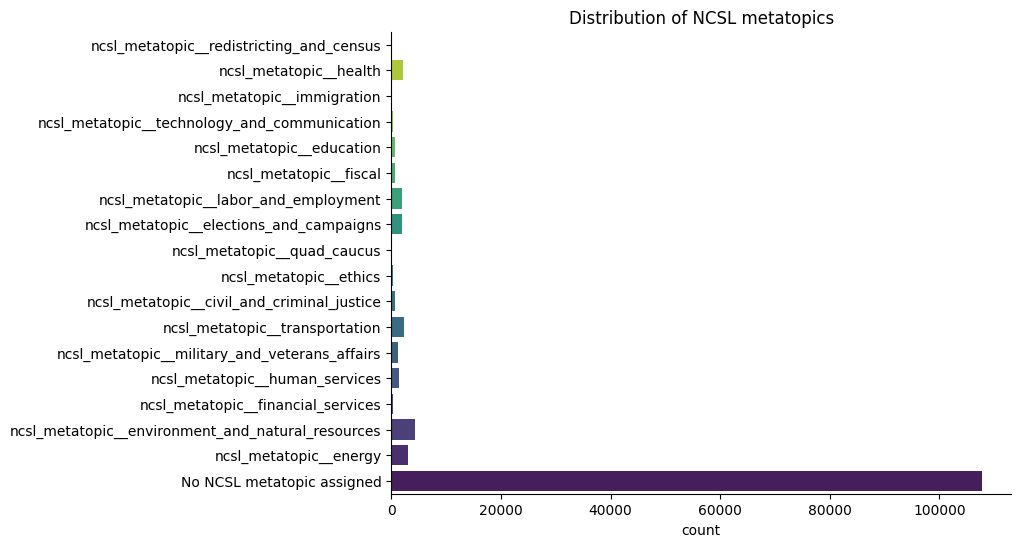

In [ ]:
#PLOT BILLS: NCSL METATOPICS IN TOTAL
print(f"number of unique topics: {len(bills_sub["ncsl_topics"].explode().unique())}")
print(f"number of unique metatopics: {len(bills_sub["ncsl_metatopics"].explode().unique())}")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y=bills_sub["ncsl_metatopics"].explode(), hue=bills_sub["ncsl_metatopics"].explode(),
              order = bills_sub["ncsl_metatopics"].explode().unique()[::-1], palette="viridis")
sns.despine()
ax.set_title('Distribution of NCSL metatopics')
ax.set_yticklabels(np.append(bills_sub["ncsl_metatopics"].explode().unique()[::-1][0:-1], "No NCSL metatopic assigned"))
plt.ylabel("")
plt.savefig("../figs/metatopic_counts.png", bbox_inches='tight', dpi=1000)

##### IDEOLOGY

In [5]:
#IDEOLOGY
bills_ide = clean_ideology(ideology, bills_sub, states_lobby)
(bills_ide.describe())
del ideology

##### POSITIONS

In [6]:
#POSITIONS
positions_sub = clean_positions(positions, bills_sub, states_lobby, time_ranges)
del positions, bills_sub

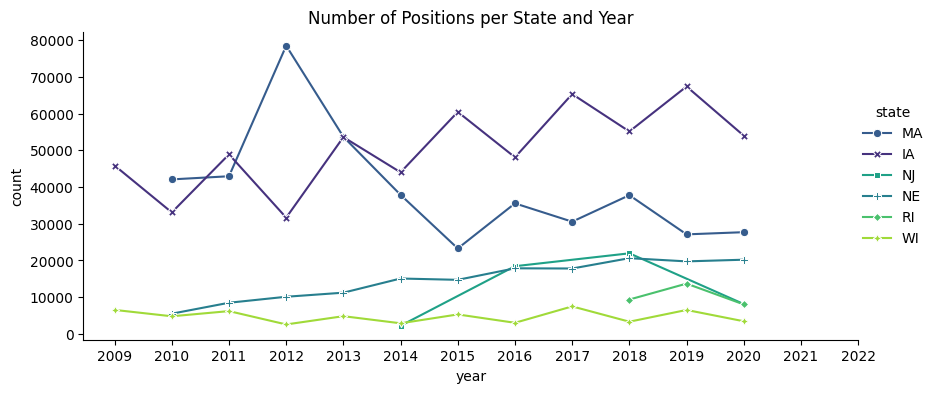

In [ ]:
#PLOTS: COUNTS (LINEPLOT)
fig, ax = plt.subplots(figsize=(10, 4))
p = sns.lineplot(data = positions_sub.value_counts(["state", "year"]).to_frame().reset_index(), 
                 x = "year", y = "count", hue = "state", palette= states_palette, style="state",
                 markers=states_markers, dashes=False)
sns.move_legend(p, "upper right", bbox_to_anchor=(1.1, 0.8),  frameon = False)
sns.despine()
ax.set_title('Number of Positions per State and Year')
plt.xticks([2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.],
           ['2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020'])
plt.savefig("../figs/positions_lineplot.png", bbox_inches='tight', dpi=1000)

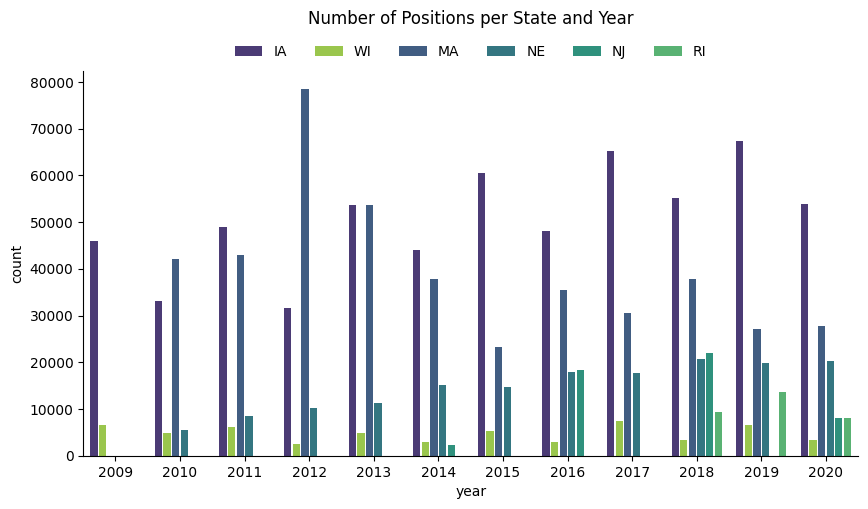

In [ ]:
#PLOT: COUNT (BARPLOT)
fig, ax = plt.subplots(figsize=(10, 5))
p = sns.countplot(positions_sub, x="year", hue="state", stat="count", palette=states_palette, gap=.15)
sns.move_legend(p, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=6,  frameon=False, title=None)
ax.set_title('Number of Positions per State and Year', y = 1.1)
sns.despine()
plt.savefig("../figs/positions_barplot.png", bbox_inches='tight', dpi=1000)

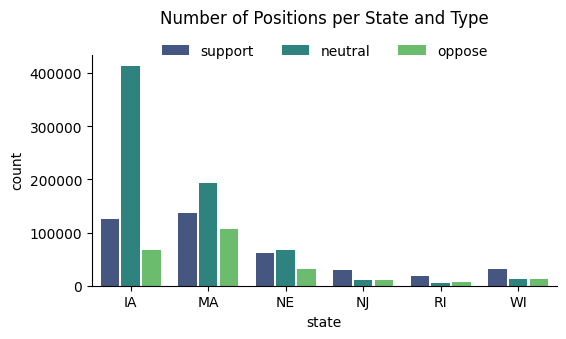

In [ ]:
# PLOT: POSITIONS TYPE
fig, ax = plt.subplots(figsize=(6, 3))
p = sns.countplot(positions_sub, x="state", hue="position_numeric", stat="count", palette="viridis", gap =.1)
sns.move_legend(p, "upper center",  bbox_to_anchor=(0.5, 1.1), ncol=3,  frameon = False, title=None)
ax.set_title('Number of Positions per State and Type', y=1.1)
sns.despine()
plt.savefig("../figs/position_type.png", bbox_inches='tight', dpi=1000)

##### BLOCKS

In [7]:
#BLOCKS
positions_blocks = clean_blocks(blocks, positions_sub, states_lobby)
print(f"number of positions in total after cleaning: {len(positions_blocks)}")
del blocks, positions_sub

number of positions in total after cleaning: 1264549


##### MERGE DATASETS: 
bills_ide & positions_blocks

In [74]:
def extract_block_counts(bills_ide, positions_blocks, out_path = "../data/preprocessed/block_array.pkl"):
    
    #define output array and dimensions: 
    block1_ls = positions_blocks["block_1"].unique()      #unique block1 values 
    bill_ls = bills_ide["state_unified_bill_id"].unique() #unique bill ids 
    #emtpty array for block counts [support, neutral, oppose]
    block_array = np.zeros([len(bill_ls), len(block1_ls),3], dtype = np.int32) 
    print(f"number of unique bills: {len(bill_ls)}\nnumber of unique blocks: {len(block1_ls)}")
    print(f"shape of block array: {block_array.shape}")

    for i in notebook.tqdm(range(len(bill_ls))):
        bill = bill_ls[i]

        ind_bill = np.asarray(bill_ls == bill).nonzero()   # get index of bill in list
        #check if bill has been lobbied on: 
        block_counts = positions_blocks[positions_blocks[   # get block counts 
                "state_unified_bill_id"]==bill].value_counts(["position_numeric", "block_1"])
        if len(block_counts)>0:
            for j, (count, block) in enumerate(zip(block_counts.values, block_counts.index)):
                ind_block = np.asarray(block1_ls == block[1]).nonzero() #get index of the block
                #check which place to put the count: 
                if block[0] == 'support':
                    block_array[ind_bill, ind_block, 0] = count
                if block[0] == 'neutral':
                    block_array[ind_bill, ind_block, 1] = count
                if block[0] == 'oppose':
                    block_array[ind_bill, ind_block, 2] = count
        
        #if bill hasnt been lobbied on skip it
        else: pass

    with open(out_path, 'wb') as file:
        pkl.dump((block_array, block1_ls, bill_ls), file)
    
    return block_array, block1_ls, bill_ls

In [ ]:
##prep block counts for merge:
block_array, block1_ls, bill_ls = extract_block_counts(bills_ide, positions_blocks)

In [ ]:
#after merging:split and save: 
y = features_ide["pass"]
X = features_ide[["state", "ncsl_metatopics", "cha", "lobbied", 
"chamber", "dem", "rep", "majority", "minority", 
              "dem_mean", "rep_mean", "diffs", "distance"]]

with open("../data/preprocessed/features.pkl", 'wb') as file:
    pkl.dump((X,y), file)